Домашнее задание 7

Цель:

Научиться использовать модели скользящего среднего (Moving Average) и ARIMA для прогнозирования временного ряда, используя встроенный датасет flights из библиотеки seaborn, а также освоить автоматический подбор параметров модели ARIMA с помощью auto_arima.

Описание задания:

Ваша задача — проанализировать данные о количестве авиапассажиров, построить модель скользящего среднего (MA) и модель ARIMA, автоматически подобрать параметры для ARIMA с помощью библиотеки auto_arima, а затем сравнить прогнозы обеих моделей.

Шаги:

1. Загрузка данных:
- Используйте встроенный датасет flights из библиотеки seaborn.
2. Простое сглаживание (Moving Average):
- Примените скользящее среднее с окном 12 месяцев (один год) для данных.
- Постройте график с исходными данными и результатом применения скользящего среднего.
3. Подбор параметров ARIMA с помощью auto_arima:
- Используйте библиотеку pmdarima для автоматического подбора параметров модели ARIMA.
- Подберите оптимальные параметры ARIMA и выведите их на экран.
4. Построение и прогноз модели ARIMA:
- Постройте модель ARIMA с подобранными параметрами.
- Сделайте прогноз на следующие 12 месяцев и выведите его на график.
5. Сравнение:
- Сравните результаты скользящего среднего и ARIMA на одном графике.
- Сделайте выводы: какие прогнозы более точные и стабильные?

In [1]:
#!pip install pmdarima

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import pmdarima as pm
from dateutil.relativedelta import relativedelta
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Загрузка датасета, вывод первых 15 строк и сводной информации
flights = sns.load_dataset("flights")
print(flights.head(15))
print('-' * 40)
print(flights.info())

    year month  passengers
0   1949   Jan         112
1   1949   Feb         118
2   1949   Mar         132
3   1949   Apr         129
4   1949   May         121
5   1949   Jun         135
6   1949   Jul         148
7   1949   Aug         148
8   1949   Sep         136
9   1949   Oct         119
10  1949   Nov         104
11  1949   Dec         118
12  1950   Jan         115
13  1950   Feb         126
14  1950   Mar         141
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB
None


В датасете следующие данные:
1. year - год наблюдения (числовой)
2. month - месяц наблюдения (категориальный)
3. passengers - количество пассажиров (числовой)

In [3]:
# Подготовка датафрейма, перед началом построения графиков и работы с моделями

def get_month_number(short_month):
    '''Функция определяет номер месяца, исходя из сокращённой формы написания названия месяца.
    Нумерация месяцев начинается с нулевого значения (k - 1) специально для дальнейших действий.'''
    month_dict = dict((v, k - 1) for k, v in enumerate(calendar.month_abbr))
    return month_dict[short_month]

# Добавление столбца с номерами месяцов (счёт начинается с нуля)
flights['month_numbers'] = [get_month_number(month) for month in flights['month']]

# Преобразование столбца с номерами годов, в формат дат
flights['year'] = flights['year'].apply(lambda year: pd.to_datetime(f"{year}-01-01"))

# Добавление месяцев к дате
flights['year'] = flights.apply(lambda flights: flights['year'] + relativedelta(months = flights['month_numbers']), axis = 1)

# Удаление более не нужных столбцов
flights = flights.drop(['month_numbers', 'month'], axis = 1)

# Преобразование столбца с датами в индексы, для более наглядного отображения на графике ниже
flights = flights.set_index('year')
#flights = flights.set_index('year', drop = False)
flights

,passengers
year,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


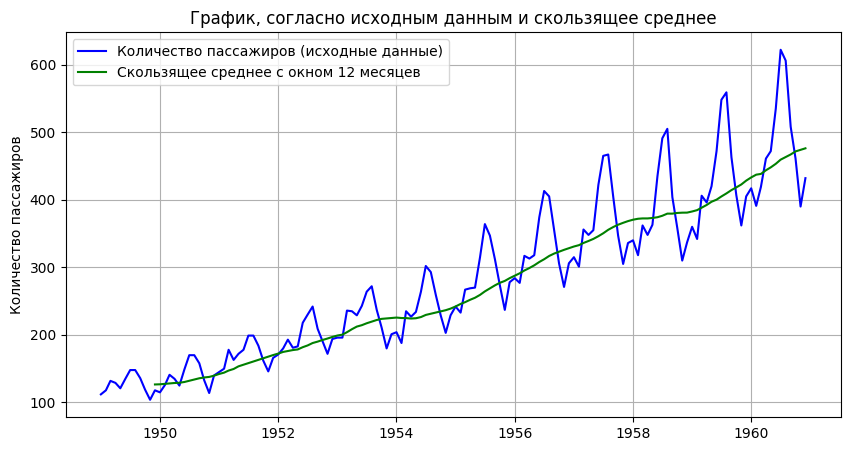

In [24]:
# Расчёт скользящего среднего с окном 12 месяцев
ma12 = flights['passengers'].rolling(window = 12).mean()

# Создание визуализации
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(flights['passengers'], color = 'blue', label = 'Количество пассажиров (исходные данные)')
ax.plot(ma12, color = 'green', label = 'Скользящее среднее с окном 12 месяцев')
ax.legend(loc = 'upper left')
ax.set_title('График, согласно исходным данным и скользящее среднее')
ax.set_ylabel('Количество пассажиров')
plt.grid()  # Для отображения сетки
plt.show()

In [4]:
flights.iloc[132]  # Строка, с которой в датасете начинается последний год наблюдений

passengers    417
Name: 1960-01-01 00:00:00, dtype: int64

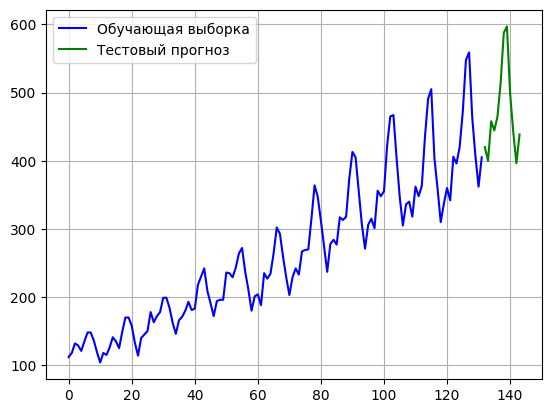

In [28]:
# Разделение датасета на train и test
# Строки 132-144 - последний календарный год в датасете, его и оставим для теста модели
train, test = train_test_split(flights, train_size = 132)

# Обучение модели
model = pm.auto_arima(train, seasonal = True, m = 12)

# Применение метода predict
forecasts = model.predict(test.shape[0])

# Создание визуализации
x = np.arange(flights.shape[0])
plt.plot(x[:132], train, c = 'blue', label = 'Обучающая выборка')
plt.plot(x[132:], forecasts, c = 'green', label = 'Тестовый прогноз')
plt.legend(loc = 'upper left')

plt.grid()  # Для отображения сетки
plt.show()

In [29]:
# Вывод наиболее оптимальных параметров для модели ARIMA
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -447.843
Date:                            Sun, 29 Sep 2024   AIC                            905.686
Time:                                    21:19:47   BIC                            919.623
Sample:                                01-01-1949   HQIC                           911.346
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5341      2.007      2.757      0.006       1.600       9.468
ar.L1          0.7049      0.095      7.393      0.000       0.518       0.892
ar.L2          0.2574      0.131      1.968      0.049       0.001       0.514
ar.L3         -0.1434      0.107     -1.338      0.181      -0.354       0.067
sigma2       101.0969     12.818      7.887      0.000      75.974     126.220
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.83
Prob(Q):                              0.96   Prob(JB):                         0.24
Heteroskedasticity (H):               1.41   Skew:                            -0.14
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
# Строительство модели, с полученными выше параметрами
model_sarimax = SARIMAX(train,
                order = (3, 0, 0),
                seasonal_order = (0, 1, 0, 12))

# Обучение модели
result_sarimax = model_sarimax.fit()

# Тестовый прогнозный период начнётся с конца обучающего периода
start = len(train)
# и закончится в конце тестового
end = len(train) + len(test) - 1

# Применение метода predict
predictions_sarimax = result_sarimax.predict(start, end)
predictions_sarimax

c:\Users\Subrik\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Subrik\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


1960-01-01    422.703386
1960-02-01    404.947179
1960-03-01    466.293259
1960-04-01    454.781298
1960-05-01    476.848630
1960-06-01    527.162828
1960-07-01    601.449812
1960-08-01    610.821694
1960-09-01    513.229990
1960-10-01    455.692622
1960-11-01    409.200050
1960-12-01    450.754164
Freq: MS, Name: predicted_mean, dtype: float64

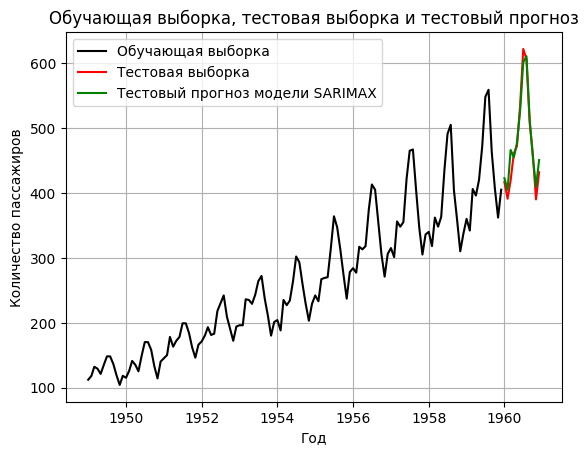

In [32]:
# Вывод трёх кривых (обучающая, тестовая выборка и тестовый прогноз)
plt.plot(train, color = 'black', label = 'Обучающая выборка')
plt.plot(test, color = 'red', label = 'Тестовая выборка')
plt.plot(predictions_sarimax, color = 'green', label = 'Тестовый прогноз модели SARIMAX')
plt.legend(loc = 'upper left')

# Заголовок и подписи к осям
plt.title('Обучающая выборка, тестовая выборка и тестовый прогноз')
plt.ylabel('Количество пассажиров')
plt.xlabel('Год')

plt.grid()  # Для отображения сетки
plt.show()

Модель SARIMAX с параметрами, полученными в результате работы auto_arima, выдала довольно точный результат - кривые тестовой выборки и тестового прогноза не совсем идентичны, но довольно близки. В процессе исследования, получилось определить ещё один набор параметров, с хорошими результатами прогнозирования - SARIMAX(1, 0, 2)x(1, 1, 2, 12)

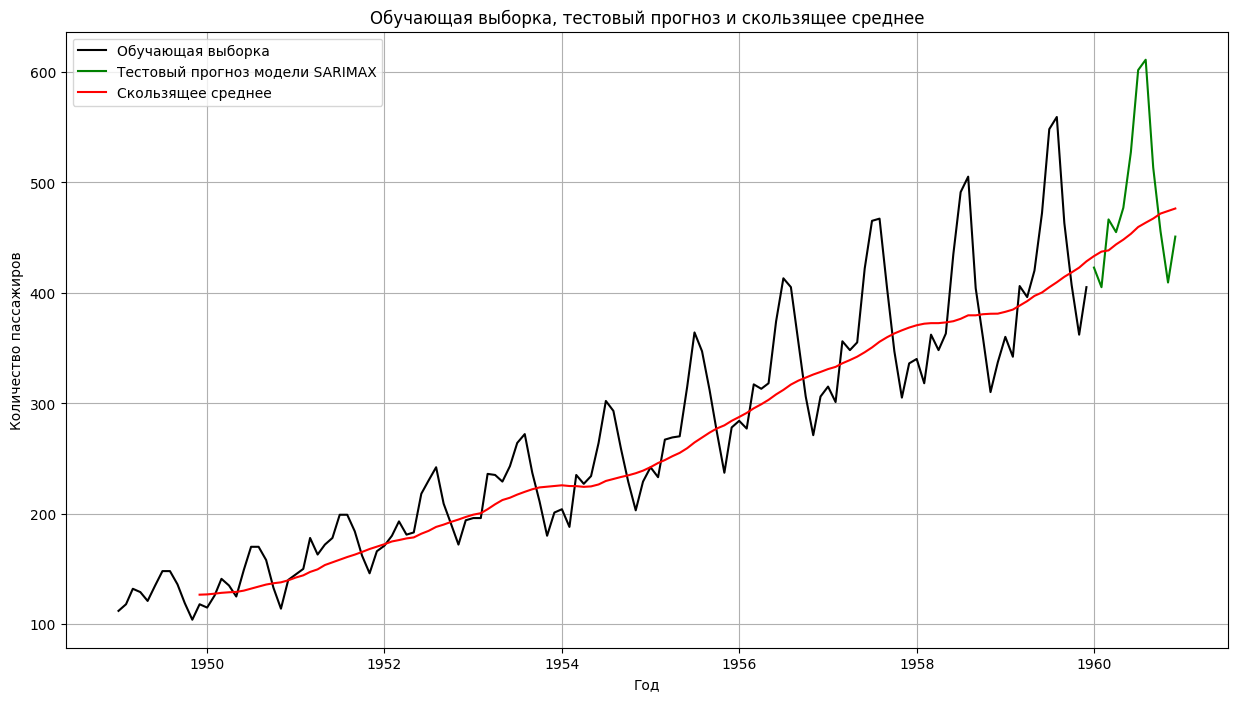

In [30]:
# Создание визуализации и сравнение результатов работы
fig, ax = plt.subplots(figsize = (15, 8))
ax.plot(train, color = 'black', label = 'Обучающая выборка')
ax.plot(predictions_sarimax, color = 'green', label = 'Тестовый прогноз модели SARIMAX')
ax.plot(ma12, color = 'red', label = 'Скользящее среднее')
ax.legend(loc = 'upper left')

# Заголовок и подписи к осям
ax.set_title('Обучающая выборка, тестовый прогноз и скользящее среднее')
ax.set_ylabel('Количество пассажиров')
ax.set_xlabel('Год')

plt.grid()  # Для отображения сетки
plt.show()

- Сравните результаты скользящего среднего и ARIMA на одном графике.

Скользящее среднее показывает усреднённые данные за заданный период. По нему можно увидеть тренд и исходя из имеющихся данных, оценить картину в общем, дать прогноз движения кривой на графике в перспективе.

Применимо к датасету flights, в сравнении со скользящим средним, ARIMA даёт значительно более точное представление, о количестве пассажиров в прогнозируемом году. С точностью до календарного месяца.

- Сделайте выводы: какие прогнозы более точные и стабильные?

Прогнозы скользящего среднего и ARIMA достаточно наглядные, на оба можно ориентироваться. Только применение у этих прогнозов разное - если требуется понять общий тренд на конкретный период в перспективе, то будет достаточно рассчитать скользящее среднее и вывести на графике. Если требуются более детальные прогнозы, то тогда нужно строить модели ARIMA и работать с их параметрами.